# Word Vectors

En este trabajo, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).




# Results
In this exercise 3 Networks where trained.

| Network                               | Test-Accuracy | Training-time (s)  |
| ------------------------------------- |:-------------:| :-----------------:|
CNN Network with pre-trained embeddings | 0.778         |      57.5          |
CNN Network                             | 0.699         |      32.7          |
RNN Network with pre-trained embeddings | 0.754         |     379            |

Based on Test Accuracy and Training time the CNN with pre-trained embeddings would be the prefered solution.

# Load the dataset
* Load the dataset
* Calculate the mean text length
* Generate a corpus of words in the index

In [1]:
import numpy as np
np.random.seed(4422)

from tensorflow import set_random_seed
set_random_seed(9090)

In [2]:
from keras.datasets import reuters

(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz")

Using TensorFlow backend.


2113536/2110848 [==============================] - 1s 0us/step


In [3]:
import keras
NUM_CLASSES = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [4]:
# Extract the length of the different stories
lens = [len(x) for x in x_train]

In [5]:
# Look at the different Story lengths
sl_min, sl_mean, sl_max = np.min(lens), np.mean(lens), np.max(lens)
sl_min, sl_mean, sl_max

(13, 145.5398574927633, 2376)

In [6]:
TEXT_LEN = int(sl_mean)
#TEXT_LEN = 200

In [7]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

557056/550378 [==============================] - 1s 1us/step


# Load pre-trained embedding

In [8]:
def load_glove_embeddings(glove_file, corpus):
    embedding = {}
    with open(glove_file) as f:
        for line in f:
            line = line.split()
            word = line[0]
            if word in corpus:
                embedding[word] = np.asarray(line[1:], dtype='float32')
    return embedding

In [9]:
embedding = load_glove_embeddings('glove.6B.100d.txt', word_index)
EMBEDDING_DIM = embedding['the'].shape[0]

FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

In [10]:
print('Found %d out of %d words in the pre-trained embedding ...' % (len(embedding), len(word_index)))

Found 24975 out of 30979 words in the pre-trained embedding ...


In [11]:
# Add special indicators to embedding
word_index = {k:v+3 for k, v in word_index.items()}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNKNOWN>'] = 2
word_index['<UNUSED>'] = 3

# Prepare text
Cut the text fragments to the same length; based on the average text length calculated previously

In [12]:
rev_word_index = {ix:word for word, ix in word_index.items()}

In [13]:
def translateText(sequence, rwi):
    return [rwi.get(s) for s in sequence]

In [14]:
# Look the N most common words
translateText(range(10), rev_word_index)

['<PAD>',
 '<START>',
 '<UNKNOWN>',
 '<UNUSED>',
 'the',
 'of',
 'to',
 'in',
 'said',
 'and']

In [15]:
from keras.preprocessing.sequence import pad_sequences
x_train_cut = pad_sequences(x_train, maxlen=TEXT_LEN, value=word_index['<PAD>'], padding='post')
x_test_cut = pad_sequences(x_test, maxlen=TEXT_LEN, value=word_index['<PAD>'], padding='post')

In [16]:
# Check some texts 
' '.join(translateText(x_train_cut[2], rev_word_index))

'<START> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one split effective january 6 1987 per share amounts are calculated after preferred stock dividends loss continuing operations for the qtr 1986 includes gains of sale of investments in enron corp of 14 mln dlrs and associated companies of 4 189 000 less writedowns of investments in national intergroup inc of 11 8 mln and brae corp of 15 6 mln reuter 3 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [17]:
' '.join(translateText(x_train_cut[10], rev_word_index))

'<START> period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [18]:
' '.join(translateText(x_train_cut[42], rev_word_index))

"<START> french operators did not request any export licences at today's european community weekly cereal tender trade sources said reuter 3 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"

## Possible error
The texts above make little sense. Is there an error in the translation or have the text been processed?

# Embedding Matrix
Build the embedding matrix, in case we dont have a embedding for a word, set the vector to 0.0

In [19]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM), dtype=embedding['the'].dtype)
for w, i in word_index.items():
    if w in embedding:
        embedding_matrix[i] = embedding[w]
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [-0.40315 ,  0.16044 ,  0.2531  , ..., -1.1313  ,  0.072203,
        -0.19863 ],
       [ 0.10101 , -0.069524,  0.42737 , ...,  0.34197 ,  0.49801 ,
         0.87623 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [20]:
from matplotlib import pyplot as plt

def plot_acc(history, title="Model Accuracy", ax=None):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)        
    ax.plot(history.history['acc'])
    ax.plot(history.history['val_acc'])
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    
def plot_loss(history, title="Model Loss", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper right')

def plot_training(history):
    # Print learning progress
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  
    plot_acc(history=history, ax=axs[0])
    plot_loss(history=history, ax=axs[1])
    fig.suptitle('Training Progress')

# Train a CNN Network

In [21]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Embedding, MaxPool1D, Flatten, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]

from keras import regularizers
regularizer=regularizers.l2(0.01)

model_cnn = Sequential()
model_cnn.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=145, trainable=False))
model_cnn.add(Dropout(0.2))
model_cnn.add(Conv1D(128, 3))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation='relu', kernel_regularizer=regularizer))
model_cnn.add(Dense(NUM_CLASSES, activation='softmax'))

model_cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 145, 100)          3098400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 145, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 143, 128)          38528     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)      

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 7185 samples, validate on 1797 samples
Epoch 1/30
7185/7185 [==============================] - 3s 381us/step - loss: 3.0651 - acc: 0.4767 - val_loss: 2.3250 - val_acc: 0.6038

Epoch 00001: val_acc improved from -inf to 0.60378, saving model to weights-best.hdf5
Epoch 2/30
7185/7185 [==============================] - 2s 330us/step - loss: 2.0970 - acc: 0.6008 - val_loss: 1.7240 - val_acc: 0.6628

Epoch 00002: val_acc improved from 0.60378 to 0.66277, saving model to weights-best.hdf5
Epoch 3/30
7185/7185 [==============================] - 2s 331us/step - loss: 1.6695 - acc: 0.6465 - val_loss: 1.4494 - val_acc: 0.6923

Epoch 00003: val_acc improved from 0.66277 to 0.69226, saving model to weights-best.hdf5
Epoch 4/30
7185/7185 [==============================] - 2s 333us/step - loss: 1.4665 - acc: 0.6759 - val_loss: 1.3133 - val_acc: 0.7184

Epoch 00004: v

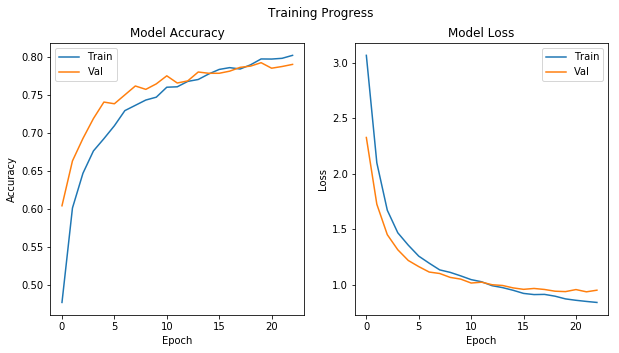

In [23]:
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

%time history_cnn = model_cnn.fit(x_train_cut, y_train, batch_size=32, epochs=30, verbose=1, validation_split=0.2, callbacks=callbacks)

test_loss, test_acc = model_cnn.evaluate(x_test_cut, y_test)
print('Test acc: %0.3f' % test_acc)

plot_training(history_cnn)

# Without pre-trained embeddings

In [24]:
# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]


from keras import regularizers
regularizer=regularizers.l2(0.01)

model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=TEXT_LEN))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 145, 100)          3098400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 145, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 143, 32)           9632      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 46)                1518      
Total params: 3,110,606
Trainable params: 3,110,606
Non-trainable params: 0
_________________________________________________________________


Train on 7185 samples, validate on 1797 samples
Epoch 1/30
7185/7185 [==============================] - 3s 457us/step - loss: 2.9598 - acc: 0.3994 - val_loss: 2.1553 - val_acc: 0.4908

Epoch 00001: val_acc improved from -inf to 0.49082, saving model to weights-best.hdf5
Epoch 2/30
7185/7185 [==============================] - 3s 391us/step - loss: 1.9651 - acc: 0.5390 - val_loss: 1.8116 - val_acc: 0.5838

Epoch 00002: val_acc improved from 0.49082 to 0.58375, saving model to weights-best.hdf5
Epoch 3/30
7185/7185 [==============================] - 3s 395us/step - loss: 1.6658 - acc: 0.6328 - val_loss: 1.6284 - val_acc: 0.6444

Epoch 00003: val_acc improved from 0.58375 to 0.64441, saving model to weights-best.hdf5
Epoch 4/30
7185/7185 [==============================] - 3s 391us/step - loss: 1.4428 - acc: 0.6841 - val_loss: 1.4890 - val_acc: 0.6789

Epoch 00004: val_acc improved from 0.64441 to 0.67891, saving model to weights-best.hdf5
Epoch 5/30
7185/7185 [=============================

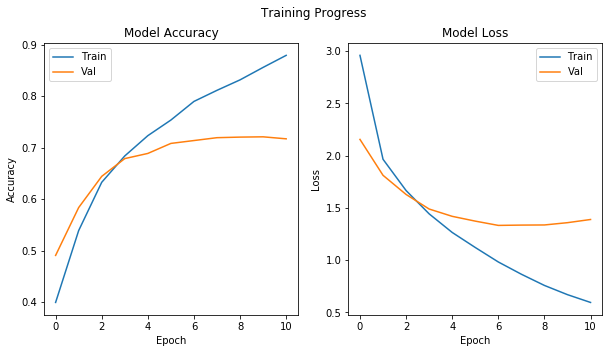

In [25]:
model_cnn_own = model
model_cnn_own.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

%time history = model_cnn_own.fit(x_train_cut, y_train, batch_size=64, epochs=30, verbose=1, validation_split=0.2, callbacks=callbacks)

test_loss, test_acc = model_cnn_own.evaluate(x_test_cut, y_test)
print('Test acc: %0.3f' % test_acc)

plot_training(history)

# RNN Network

In [26]:
from keras.layers import LSTM

# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]

from keras import regularizers
regularizer=regularizers.l2(0.01)

model = Sequential()
model.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=145, trainable=False))
model.add(LSTM(128))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 145, 100)          3098400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 46)                5934      
Total params: 3,221,582
Trainable params: 123,182
Non-trainable params: 3,098,400
_________________________________________________________________


Train on 7185 samples, validate on 1797 samples
Epoch 1/30
7185/7185 [==============================] - 15s 2ms/step - loss: 2.4699 - acc: 0.3900 - val_loss: 2.0866 - val_acc: 0.4680

Epoch 00001: val_acc improved from -inf to 0.46800, saving model to weights-best.hdf5
Epoch 2/30
7185/7185 [==============================] - 13s 2ms/step - loss: 2.0630 - acc: 0.4608 - val_loss: 1.9153 - val_acc: 0.4942

Epoch 00002: val_acc improved from 0.46800 to 0.49416, saving model to weights-best.hdf5
Epoch 3/30
7185/7185 [==============================] - 13s 2ms/step - loss: 1.8821 - acc: 0.5048 - val_loss: 1.7679 - val_acc: 0.5648

Epoch 00003: val_acc improved from 0.49416 to 0.56483, saving model to weights-best.hdf5
Epoch 4/30
7185/7185 [==============================] - 13s 2ms/step - loss: 1.6871 - acc: 0.5797 - val_loss: 1.6453 - val_acc: 0.5810

Epoch 00004: val_acc improved from 0.56483 to 0.58097, saving model to weights-best.hdf5
Epoch 5/30
7185/7185 [==============================] -

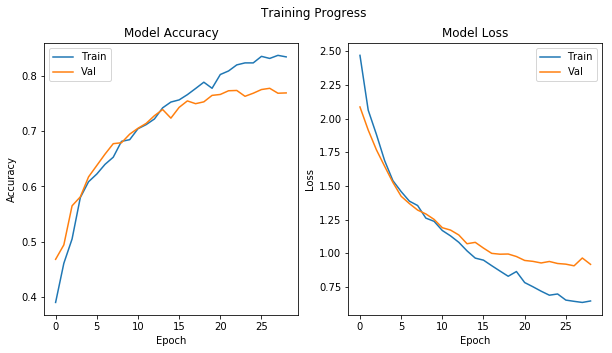

In [27]:
model = model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

%time history = model.fit(x_train_cut, y_train, batch_size=64, epochs=30, verbose=1, validation_split=0.2, callbacks=callbacks)

test_loss, test_acc = model.evaluate(x_test_cut, y_test)
print('Test acc: %0.3f' % test_acc)

plot_training(history)